# DMC - Data Preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline

%run classification/utils.py
%run classification/plots.py

/Users/taahase8/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
df_train = pd.read_csv('../data/train.csv', sep='|')
df_test = pd.read_csv('../data/test.csv', sep='|')

df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [3]:
print('rows with fraud=1', df_train[df_train['fraud'] == 1].shape)
print('rows with fraud=0', df_train[df_train['fraud'] == 0].shape)

rows with fraud=1 (104, 10)
rows with fraud=0 (1775, 10)


In [4]:
df_train.insert(1, 'totalItemsScanned', df_train['scannedLineItemsPerSecond'] * df_train['totalScanTimeInSeconds'])

df_train.head()

,trustLevel,totalItemsScanned,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,29.0,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,14.0,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,13.0,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,29.0,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,27.0,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


The dataset only contains _104_ rows where `fraud=1`. This means the data is very inbalanced and it will be hard to find a good fit with only a few data points.

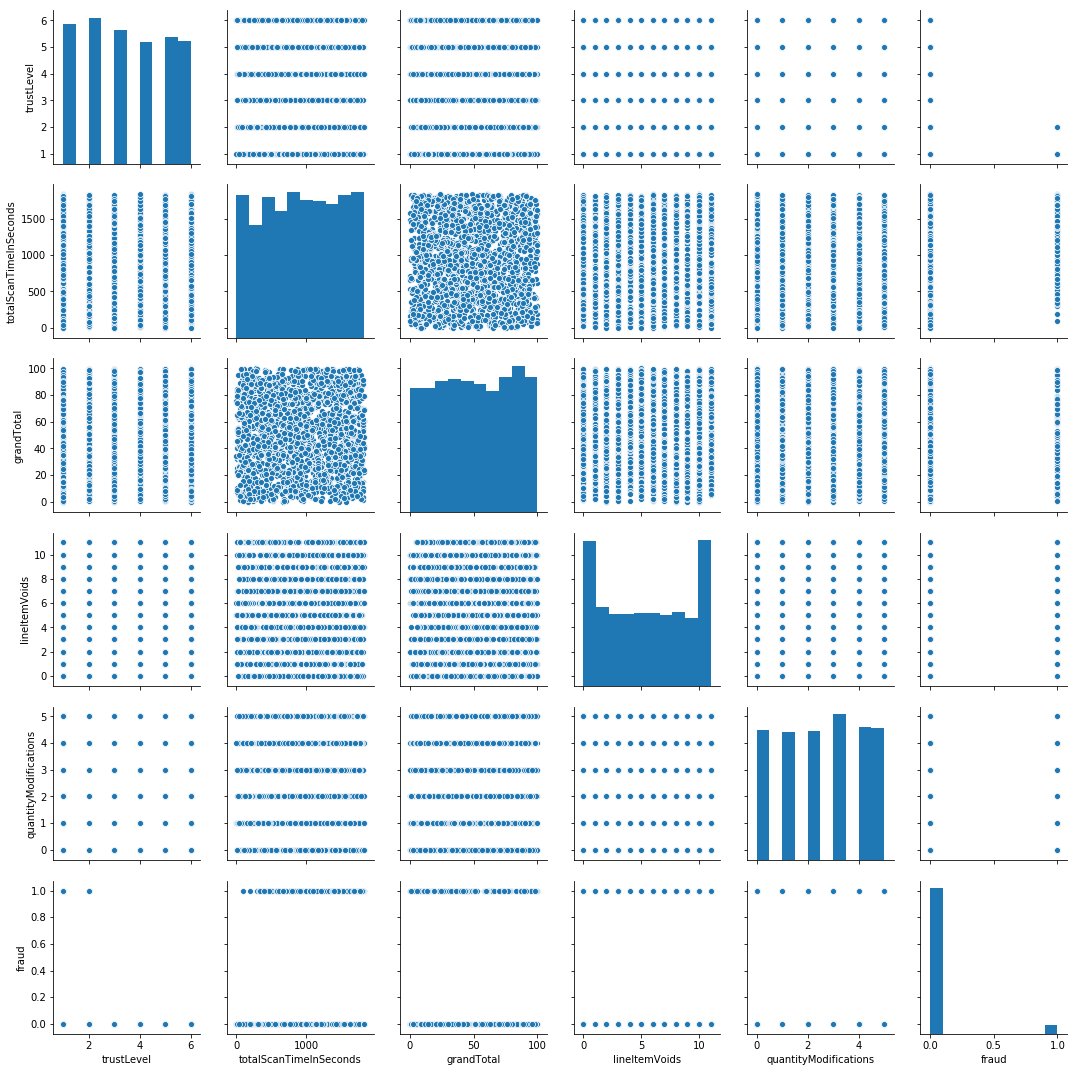

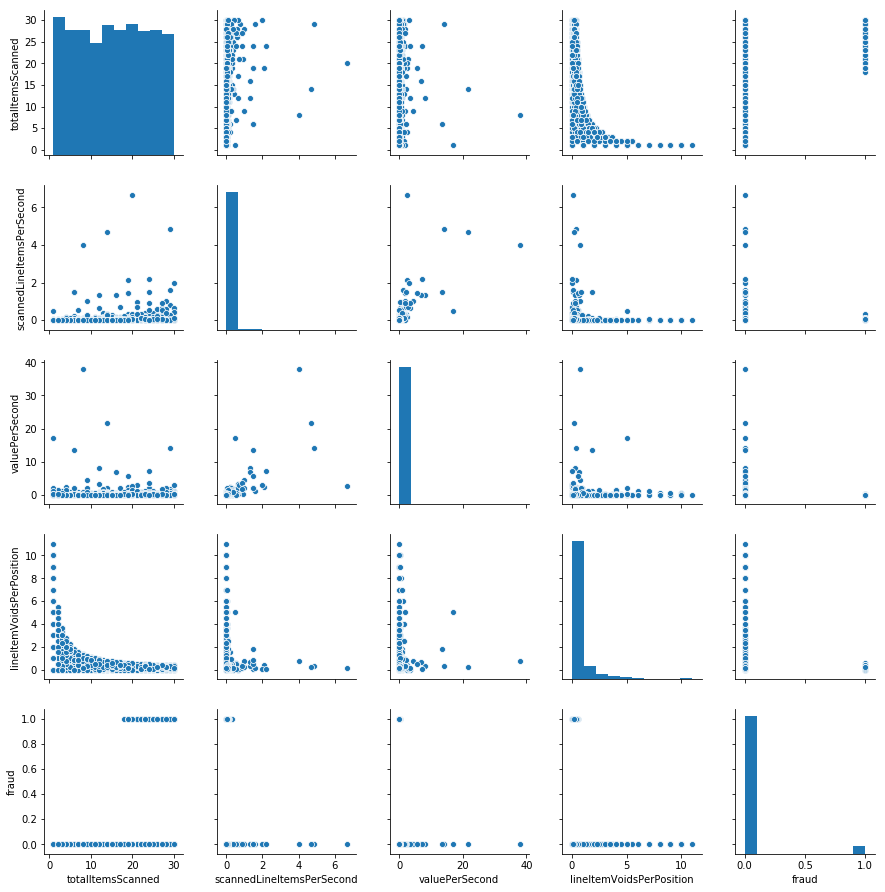

In [5]:
ax = sns.pairplot(df_train[[
    'trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
    'quantityModifications', 'fraud'
]])
ax = sns.pairplot(df_train[[
    'totalItemsScanned','scannedLineItemsPerSecond','valuePerSecond','lineItemVoidsPerPosition', 'fraud'
]])

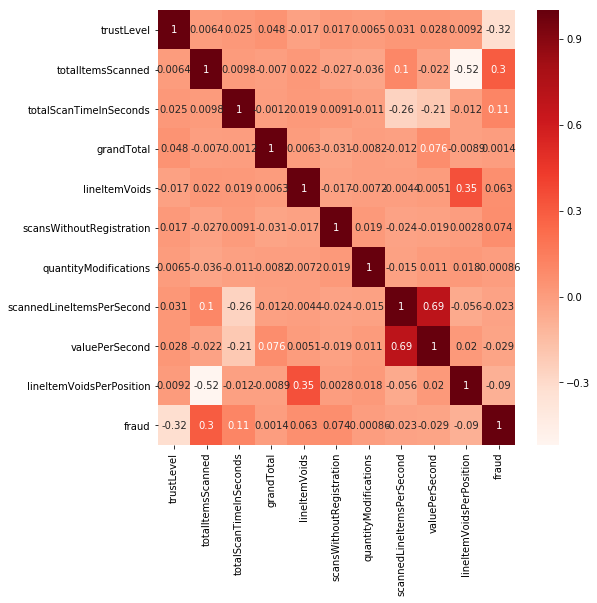

In [6]:
# Using Pearson Correlation
plt.figure(figsize=(8, 8))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
# Correlation with output variable
cor_target = abs(cor['fraud'])
cor_target.sort_values(ascending=False)

fraud                        1.000000
trustLevel                   0.319765
totalItemsScanned            0.298423
totalScanTimeInSeconds       0.110414
lineItemVoidsPerPosition     0.090116
scansWithoutRegistration     0.074123
lineItemVoids                0.063496
valuePerSecond               0.028873
scannedLineItemsPerSecond    0.023085
grandTotal                   0.001421
quantityModifications        0.000864
Name: fraud, dtype: float64

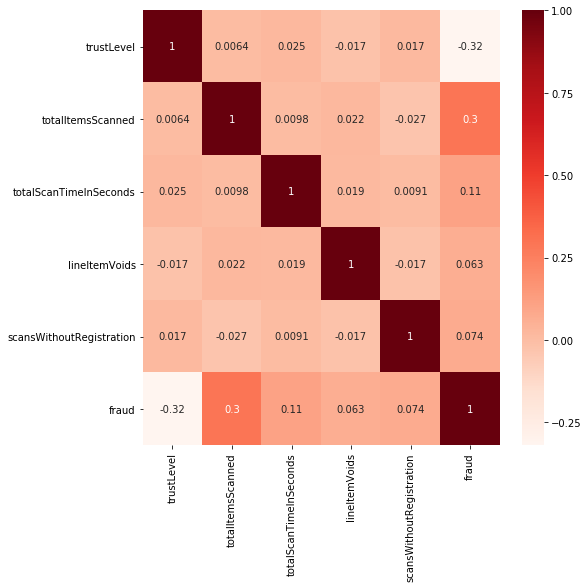

fraud                       1.000000
trustLevel                  0.319765
totalItemsScanned           0.298423
totalScanTimeInSeconds      0.110414
scansWithoutRegistration    0.074123
lineItemVoids               0.063496
Name: fraud, dtype: float64

In [8]:
df_train_lean = df_train.drop(columns=[
    'scannedLineItemsPerSecond', 'lineItemVoidsPerPosition', 'valuePerSecond',
    'quantityModifications', 'grandTotal'
])
cor = df_train_lean.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
cor_target = abs(cor['fraud'])
cor_target.sort_values(ascending=False)

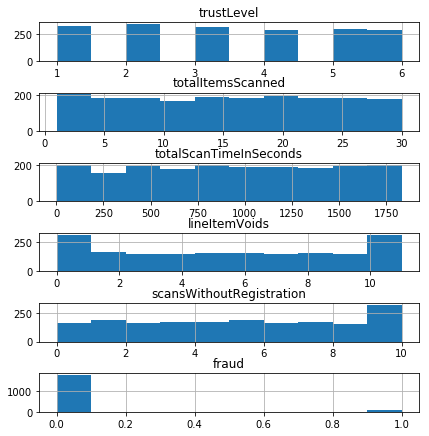

In [9]:
def plot_histograms(df):
    fig, axs = plt.subplots(len(df.columns), figsize=(6,6))
    fig.tight_layout()
    for i, col in enumerate(df.columns):
        axs[i].set_title(col)
        df[col].hist(ax=axs[i])

plot_histograms(df_train_lean)

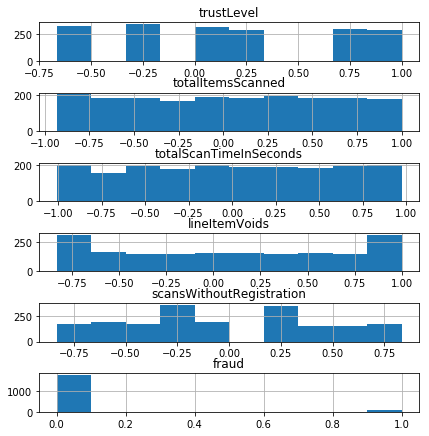

In [10]:
scaler = preprocessing.RobustScaler()

scaled_df = scaler.fit_transform(df_train_lean)
scaled_df = pd.DataFrame(scaled_df, columns=df_train_lean.columns)
plot_histograms(scaled_df)

In [6]:
def generate_baselines(y):
    print('100% accuracy score:', score_evaluation(y, y))
    print('always predicting opposite:', score_evaluation(y, (-y.copy()) + 1))
    print('always predicting 0:', score_evaluation(y, np.zeros(len(y))))
    print('always predicting 1:', score_evaluation(y, np.ones(len(y))))

    pred_scores = []
    for i in range(1, 100):
        y_pred_random = np.random.randint(low=0, high=2, size=len(y))
        pred_scores.append(score_evaluation(y, y_pred_random))
    print('random:', np.mean(pred_scores))
    
print('training set:')
generate_baselines(df_train['fraud'].values)

print('\n\ntesting set:')
generate_baselines(pd.read_csv('../data/DMC-2019-realclass.csv', squeeze=True).values)

training set:
100% accuracy score: 520
always predicting opposite: -44895
always predicting 0: -520
always predicting 1: -43855
random: -22177.676767676767


testing set:
100% accuracy score: 118635
always predicting opposite: -11978485
always predicting 0: -118635
always predicting 1: -11741215
random: -5929748.03030303
